# Tarea 3

La meta de esta tarea tratar de competirle a algoritmos de reducción de dimensionalidad, y encontrar las mejores features para clusterisar el dataset [MNIST](http://yann.lecun.com/exdb/mnist/) de digitos escritos a mano que se compone de imagenes de 28x28 pixeles, se separa en 60.000 imagenes de training y 10.000 de testing. Para efectos de la tarea sólo vamos a usar 10.000 imágenes.

Esta tarea fue diseñada gracias al trabajo exploratorio y las ideas de Pablo Flores. 

### Detalles administrativos

La tarea es individual. Para la entrega, sube este notebook al cuestionario del siding, el plazo para hacerlo es el **Viernes 15 de Octubre, a las 20:00 hrs**. Te pedimos también por favor nombrar tu archivo con el formato **NumeroAlumno_Apellido_Nombre**. 

### Datos

Vamos a realizar la misma descarga al dataset MNIST que lo que hicimos para la semana 4. 

In [6]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [14]:
#Tomamos el dataset y lo dividimos en X (los pixeles) e y (el número que es). 
#Recordemos que las imágenes son 28x28 = 784 pixeles
X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 60000 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 59.8 MB


<AxesSubplot:>

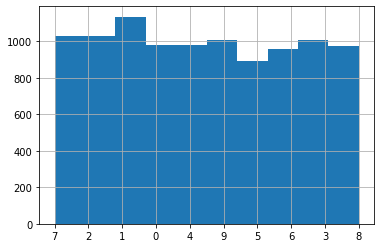

In [16]:
#Si bien los datos no están completamente balanceados, hay una buena mezcla de cada número en el dataset.
y_sample.hist()

## Parte 0.  Clusterizando en dos dimensiones

Ok! Tenemos los datos listos  [(do we?)](https://www.youtube.com/watch?v=1dwu4iVA1yo). La verdad es que si queremos hacer clusters con datos que tienen tantas dimensiones (768) vamos a necesitar harta capacidad de computo por lo que lo mejor que podemos hacer es reducir las dimensiones. En este caso vamos a reducirlas usando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), dos algoritmos de reduccion de dimensionalidad. PCA lo vamos a ver en detalle más adelante en el curso, y vamos a hablar de algoritmos como t-SNE. 

En ambos casos vamos a probar como se ve todo en dos dimensiones, y vamos a comparar los clusteres obtenidos con las etiquetas reales que nos dicen qué número es cada imagen. Partimos aplicando PCA para generar, a parir de **X_sample**, un conjunto de vectores de solo dos dimensiones, que representan una forma de representar las 784 dimensiones en solo dos. De esta forma, el conjunto **vectors_pca_2** tiene exactamente la misma cantidad de vectores que **X_sample**, cada vector de un lado está en correspondencia con un vector del otro lado. 

In [18]:
# PCA dos dimensiones
pca_2d = PCA(n_components=2)
vectors_pca_2 = pca_2d.fit_transform(X_sample)



Ahora si estamos listos para hacer clustering con KMeans. En este caso sabemos que hay 10 digitos por lo que buscaremos 10 clusters.

In [19]:
kmeans = KMeans(n_clusters=10)
pca_clusters = kmeans.fit_predict(vectors_pca_2)

Veamos como nos queda esto si lo graficamos (esa es la gran gracia de reducir a dos dimensiones). 

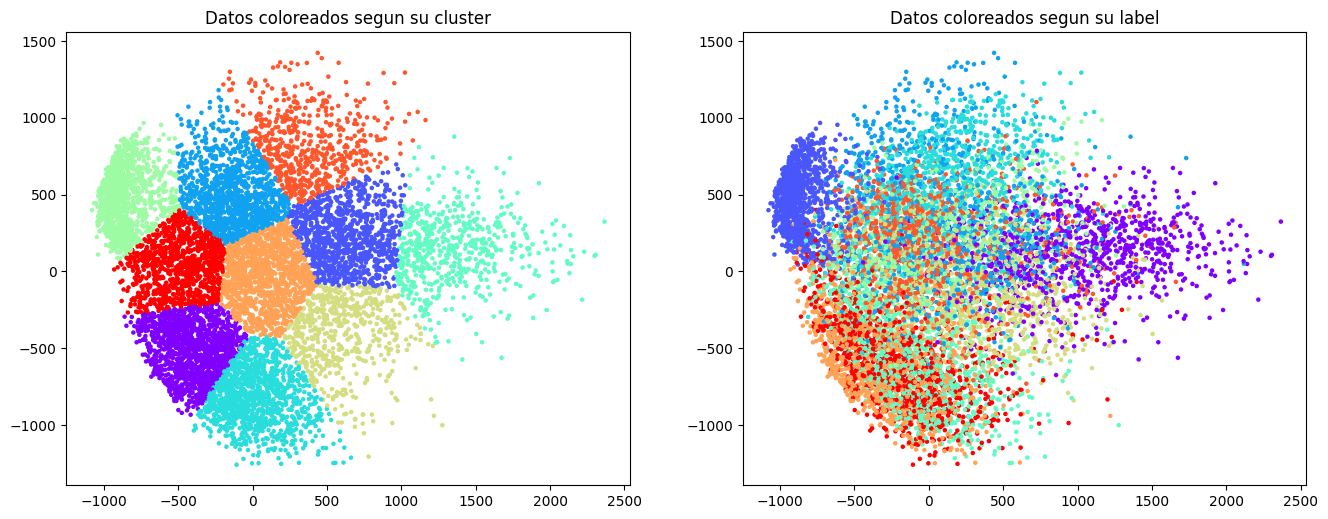

In [65]:
#Cambiamos la secuencia de categorias a enteros
labels = y_sample.astype(int)

fig, axes = plt.subplots(1, 2, dpi=100, figsize=(16,6))

axes[0].set_title("Datos coloreados segun su cluster")
axes[0].scatter(vectors_pca_2[:, 0], vectors_pca_2[:, 1], c=pca_clusters, cmap="rainbow", s=5)

axes[1].set_title("Datos coloreados segun su label")
axes[1].scatter(vectors_pca_2[:, 0], vectors_pca_2[:, 1], c=labels, cmap="rainbow", s=5)
plt.show()

Como puedes ver, hay algunos clusters que Kmeans toma bastante bien (por ejemplo, el verde de la izquierda, que corresponde al azul de la derecha). Antes de seguir, veamos como quedan los datos con otra forma de transformar **X_sample** en vectores 2D. 

In [31]:
# Y ahora tsne, esto se demora un poco (harto) más, alrededor de 1-5 minutos
tsne_2d = TSNE(n_components=2)
vectors_tsne_2 = tsne_2d.fit_transform(X_sample)

In [32]:
kmeans_tsne = KMeans(n_clusters=10)
tsne_clusters = kmeans_tsne.fit_predict(vectors_tsne_2)

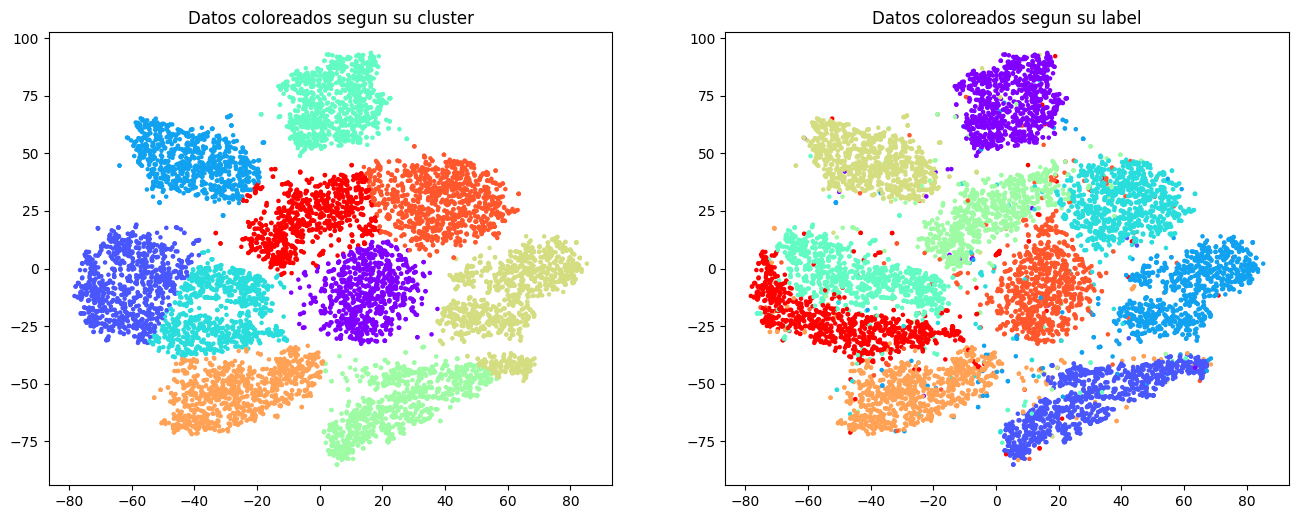

In [34]:
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(16,6))

axes[0].set_title("Datos coloreados segun su cluster")
axes[0].scatter(vectors_tsne_2[:, 0], vectors_tsne_2[:, 1], c=tsne_clusters, cmap="rainbow", s=5)

axes[1].set_title("Datos coloreados segun su label")
axes[1].scatter(vectors_tsne_2[:, 0], vectors_tsne_2[:, 1], c=labels, cmap="rainbow", s=5)
plt.show()

Definitivamente se ven más claros los clusters y en general KMeans logra asignar a un mismo cluster los mismos digitos, pero se pueden ver que algunos digitos son separados en distintos clusters. Pronto veremos las ventajas de hacer diferentes reducciones de dimensionalidad, pero por ahora: sigamos con la tarea. 

### Pregunta a)

Normalmente no podemos usar a los algoritmos de clustering para clasificar, por que no tenemos información sobre la clase (clustering es no-supervisado). Sin embargo, ahora si tenemos información, así que podemos pedir el _accuracy_ tal como lo hacíamos con regresiones logísticas, KNN o árboles. Mira el accuracy score de este código. Es super bajo, comparable con un algoritmo aleatorio. Sin embargo, en la imagen de arriba vemos que (salvo algunos errores puntuales), los clusteres quedan relativamente bien. ¿Qué está pasando?

In [57]:
from sklearn.metrics import accuracy_score

#recuerda que labels es el vector y_cample pero transformado a enteros. 

accuracy_score(labels,tsne_clusters)

0.1018

**respuesta pregunta a)**

## Parte 1.  Clusterizando en 4 dimensiones, comparación con silhouette score. 

Lo primero que vas a hacer es volver a realizar kmeans sobre los vectores **vectors_pca_4**, que tienen 4 dimensiones. Luego de eso, compararemos qué tan bueno es el clustering. 


In [54]:
pca_4d = PCA(n_components=4)
vectors_pca_4 = pca_4d.fit_transform(X_sample)

En esta parte usaremos [`silhouette score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)

### **Pregunta b)** 
Explica brevemente como funciona el silhouette score. Que valores puede tomar y que significan?



**Respuesta pregunta b):** 

Comparamos el silhouette score kmeans sobre **vectors_pca_4** y sobre **vectors_pca_2** y sobre **vectors_tsne_2**. El score es un buen comparador para clústeres de la misma dimensión, pero tiende a disminuir cuando se comparan datasets con mayor dimensión versus datasets con menor dimension 

In [60]:
from sklearn.metrics import silhouette_score

silhouette_score(vectors_pca_2, pca_clusters)

0.360674718473813

In [62]:
silhouette_score(vectors_tsne_2, tsne_clusters)

0.4630604

In [58]:


pca_4_clusters = kmeans.fit_predict(vectors_pca_4)

silhouette_score(vectors_pca_4, pca_4_clusters)

0.25568733186433856

## Parte 2.  Feature selection

Como comentábamos, no podemos correr kmeans sobre 700+ dimensiones, y aún no comprendemos bien de qué forma se reduce la dimensionalidad. 

Por otro lado, dado que el silhouette score nos sirve para comparar clusteres con la misma dimensión, podemos pensar en el siguiente código, para elegir las mejores **4** dimensiones para clusterizar. 

    4dim = []
    Para i entre 1 y 4: 
        Sea j la dimensión (entre 1 y 784, sin contar las dimensiones que ya están en 4dim) tales que clusterizar con j y las dimensiones en 4dim entrega el mejor silhouette score. Agregar j a 4dim. 
    



### Pregunta c) 
Implementa el pseudocódigo de arriba. Informa las 4 dimensiones, usa kmeans sobre el dataset reducido solo a esas 4 dimensiones (no usando PCA ni nada, simplemente borrando el resto). Llamale **vectors_4dim** a ese dataset. Clusteriza ese dataset, y compara con lo que obtuviste para **vectors_pca_4** (almacenado en **pca_4_clusters**). ¿Cuál tiene mejor silhouette score? 

In [ ]:
### Respuesta pregunta c

### Pregunta d) 
Ahora realiza una comparación visual eligiendo las primeras dos dimensiones de **vectors_4dim**, tal como lo hicimos arriba con los clusteres realizados con dos dimensiones. ¿Qué está pasando? ¿Puedes ver una limitación del silhouette score?

In [ ]:
### Respuesta pregunta d


## Parte 3. Epílogo

Una posible forma de mejorar el pseudocódigo de la parte 2 es considerar solo dimensiones que tengan algún grado de dispersion. Por ejemplo, uno podría medir cuan lejos están los puntos del centroide, y seleccionar solo aquellos puntos que tengan un cierto mínimo de distancia. 

Para ser más específicos, sea $X = x_1,\dots,x_n$ un conjunto de vectores. Para una dimensión $d$ en particular de $X$, definimos la dispersión de $d$ como 
$$\sum_{1 \leq i \leq n} \frac{|x_i^d - (\frac{\sum x_i^d)}{n})|}{n}, $$
donde $x_i^d$ se refiere a la dimensión (o componente) $d$ del vector $x_i$. Es decir, para la dispersión calculamos el valor absoluto de la diferencia entre la componente $d$ de un vector y el promedio de la componente $d$ de cada vector, todo eso dividido por $n$. 



### Pregunta e) 
Ahora vuelve a entrenar tu algoritmo, pero tomando solo aquellas dimensiones cuya dispersión esté en el 50% más alto de las dispersiones de todas las dimensiones. ¿Cambia algo la clusterización? ¿Cómo crees que se podría mejorar aún más?

In [ ]:
### Respuesta pregunta e